# 0) LIBRARIES, FUNCTIONS, READ DATA

# Libraries

In [69]:
!pip install scikit-learn >/dev/null
!pip install keras >/dev/null
!pip install scikeras >/dev/null
!pip install gplearn >/dev/null

# Classic libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import os
import itertools
import tensorflow as tf
import time
import random
from tensorflow import keras

# ML Modules
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.svm import LinearSVR, SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.inspection import permutation_importance
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

from keras.models import Sequential
from keras.layers import Dense
from scikeras.wrappers import KerasRegressor
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler, EarlyStopping, Callback

from gplearn.genetic import SymbolicRegressor

from xgboost import XGBRegressor

from hyperopt import fmin, tpe, hp, Trials, STATUS_OK, STATUS_FAIL

# Other
from google.colab import files

SEED

In [70]:
# Set random seed for Python environment
random.seed(16)
# Set random seed for NumPy
np.random.seed(16)
# Set random seed for TensorFlow and Keras
tf.random.set_seed(16)
keras.utils.set_random_seed(16)
tf.config.experimental.enable_op_determinism()

#Functions

In [71]:
def get_xy(data):
    if isinstance(data, np.ndarray):
        X = data[:, :-1]
        y = data[:, -1].reshape(-1, 1)
    elif isinstance(data, pd.DataFrame):
        X = pd.DataFrame(data[data.columns[:-1]].values, columns = list(data.columns[:-1]))
        y = pd.DataFrame(data[data.columns[-1]].values.reshape(-1, 1), columns = data.columns[-1:])
    else:
        raise ValueError("Input data must be either a pandas DataFrame or a numpy array")

    return X, y

In [72]:
def eval_model(model, y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)

    if hasattr(model, 'coef_'):
        coeff = model.coef_
        flat_coeff = coeff.flatten()
    else:
        flat_coeff = None

    if hasattr(model, 'intercept_'):
        intercept = model.intercept_
    else:
        intercept = None

    eval_metrics = {
            'r2': r2,
            'mse': mse,
            'rmse': rmse,
            'coeff': flat_coeff,
            'intercept': intercept
        }

    return eval_metrics

In [73]:
def crossval_model(model, X_train, y_train, X_test, y_test, cv=5, scoring='r2', random_state=16):

    cv_splitter = KFold(n_splits=cv, shuffle=True, random_state=random_state)
    cv_scores = cross_val_score(model, X_train, y_train, cv=cv_splitter, scoring=scoring)
    mean_train_score = np.round(cv_scores.mean(), 3)

    test_score = np.round(model.score(X_test, y_test), 3)

    score_difference = np.abs(mean_train_score - test_score)

    crossval_metrics = {
        'mean_train_score': mean_train_score,
        'test_score': test_score,
        'score_difference': score_difference,
    }

    return crossval_metrics

In [74]:
def crossval_neural(model_func, X, y, X_test, y_test, epochs, batch_size, cv=5, random_state=16):
    np.random.seed(random_state)

    # Initialize lists to hold metrics for each fold
    train_mse_scores = []
    train_r2_scores = []
    val_mse_scores = []
    val_r2_scores = []

    cv_splitter = KFold(n_splits=cv, shuffle=True, random_state=random_state)

    for train_index, val_index in cv_splitter.split(X):
        # Split the data
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]

        # Create a new instance of the model for each fold
        model = model_func()

        # Fit the model
        model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)

        # Predict on the training and validation set
        y_train_pred = model.predict(X_train)
        y_val_pred = model.predict(X_val)

        # Calculate MSE and R2 for training and validation sets
        train_mse = mean_squared_error(y_train, y_train_pred)
        train_r2 = r2_score(y_train, y_train_pred)

        val_mse = mean_squared_error(y_val, y_val_pred)
        val_r2 = r2_score(y_val, y_val_pred)

        # Append the scores
        train_mse_scores.append(train_mse)
        train_r2_scores.append(train_r2)
        val_mse_scores.append(val_mse)
        val_r2_scores.append(val_r2)

    # Calculate mean and std of the scores
    mean_train_mse_uns = np.mean(train_mse_scores)
    mean_train_mse1 = scaler_y.inverse_transform(np.reshape(mean_train_mse_uns, [-1,1]))[0,0]
    mean_train_mse2 = scaler_y.inverse_transform(np.reshape(mean_train_mse1, [-1,1]))[0,0]
    mean_train_rmse = np.sqrt(mean_train_mse2)
    mean_train_r2 = np.mean(train_r2_scores)

    mean_val_mse_uns = np.mean(val_mse_scores)
    mean_val_mse1 = scaler_y.inverse_transform(np.reshape(mean_val_mse_uns, [-1,1]))[0,0]
    mean_val_mse2 = scaler_y.inverse_transform(np.reshape(mean_val_mse1, [-1,1]))[0,0]
    mean_val_rmse = np.sqrt(mean_val_mse2)
    mean_val_r2 = np.mean(val_r2_scores)


    # Fit the model to the entire training data
    final_model = model_func()
    final_model.fit(X, y, epochs=epochs, batch_size=batch_size, verbose=0)

    # Evaluate the model on the test data
    y_test_pred = final_model.predict(X_test)

    test_mse_uns = mean_squared_error(y_test, y_test_pred)
    test_mse1 = scaler_y.inverse_transform(np.reshape(test_mse_uns, [-1,1]))[0,0]
    test_mse2 = scaler_y.inverse_transform(np.reshape(test_mse1, [-1,1]))[0,0]
    test_rmse = np.sqrt(test_mse2)
    test_r2 = r2_score(y_test, y_test_pred)

    # Package cross-validation metrics
    crossval_metrics = {
        'mean_train_r2': mean_train_r2,
        'mean_val_r2': mean_val_r2,
        'test_r2': test_r2,
        'mean_train_mse': mean_train_mse2,
        'mean_val_mse': mean_val_mse2,
        'test_mse': test_mse2,
        'mean_train_rmse': mean_train_rmse,
        'mean_val_rmse': mean_val_rmse,
        'test_rmse': test_rmse
    }

    return crossval_metrics

In [75]:
def get_poly_feature_names(input_features, degree):

  cols = ["bias"]  # Add bias term
  cols.extend(input_features)  # Add original features

  for i in range(2, degree + 1):
    # Squared terms for each original feature
    for feature in input_features:

      cols.append(feature + '^2')
    # Interaction terms (without duplicates)
    for feature_combo in itertools.combinations(input_features, i):
      cols.append('*'.join(feature_combo))


  return cols

In [76]:
def plot_history(history):
  loss_arr = np.reshape(np.array(history.history['loss']),[-1,1])
  loss_uns1 = scaler_y.inverse_transform(loss_arr)
  loss_uns2 = scaler_y.inverse_transform(loss_uns1)

  val_arr = np.reshape(np.array(history.history['val_loss']),[-1,1])
  val_uns1 = scaler_y.inverse_transform(val_arr)
  val_uns2 = scaler_y.inverse_transform(val_uns1)

  plt.plot(loss_uns2,label='loss')
  plt.plot(val_uns2,label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('MSE')
  plt.legend()
  plt.grid(True)
  plt.show()

In [77]:
def plot_history_lr(history, learning_rate):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))

  ax1.plot(history.history['loss'],label='loss')
  ax1.plot(history.history['val_loss'],label='val_loss')
  ax1.set_xlabel('Epoch')
  ax1.set_ylabel('MSE')
  ax1.legend()
  ax1.grid(True)

  ax2.plot(learning_rate, history.history['loss'],label='learning rate', color = 'indianred')
  ax2.set_xlabel('Learning rate')
  ax2.set_xscale('log')
  ax2.set_ylabel('Loss')
  ax2.legend()

  ax2.grid(True)

  plt.show()

# Read dataset, pin=0



In [78]:
dataset_pd = pd.read_excel("/content/dataset_ml.xlsx")
cols = ["couple", "spec", "temp", "hard_ratio", "cof", "volume"]
dataset_pd["spec"] = (dataset_pd["spec"]=="plate").astype(int)
dataset_pd.head()

,couple,spec,temp,hard_ratio,cof,volume
0,1,1,300,0.899676,0.58,3.976732e+08
1,1,0,300,0.899676,0.58,7.115535e+07
2,1,1,700,0.899676,0.56,4.693081e+07
3,1,0,700,0.899676,0.56,2.200536e+07
4,1,1,850,0.899676,0.32,1.652195e+07


# np.arrays and pd.DataFrames

In [79]:
train_pd, test_pd = np.split(dataset_pd.sample(frac=1, random_state=16), [int(0.8*len(dataset_pd))])
dataset_np = np.array(dataset_pd)
train_np, test_np = np.array(train_pd), np.array(test_pd)

#All NUMPY ARRAYS - UNScaled
X_dataset_np = get_xy(dataset_np)[0]
y_dataset_np = get_xy(dataset_np)[1]

X_train_np = get_xy(train_np)[0]
y_train_np = get_xy(train_np)[1]

X_test_np = get_xy(test_np)[0]
y_test_np = get_xy(test_np)[1]

#All PANDAS DATAFRAMES - UNScaled
X_dataset_pd = get_xy(dataset_pd)[0]
y_dataset_pd = get_xy(dataset_pd)[1]

X_train_pd = get_xy(train_pd)[0]
y_train_pd = get_xy(train_pd)[1]

X_test_pd = get_xy(test_pd)[0]
y_test_pd = get_xy(test_pd)[1]

#All NUMPY ARRAYS - Scaled .- MINMAX  because only positive values
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train_np_scaled = scaler_X.fit_transform(X_train_np)
y_train_np_scaled = scaler_y.fit_transform(y_train_np.reshape(-1, 1))

X_test_np_scaled = scaler_X.transform(X_test_np)
y_test_np_scaled = scaler_y.transform(y_test_np)

#All PANDAS DATAFRAMES - Scaled
X_train_pd_scaled = pd.DataFrame(X_train_np_scaled, columns = list(dataset_pd.columns[:-1]))
y_train_pd_scaled = pd.DataFrame(y_train_np_scaled, columns = dataset_pd.columns[-1:])

X_test_pd_scaled = pd.DataFrame(X_test_np_scaled, columns = list(dataset_pd.columns[:-1]))
y_test_pd_scaled = pd.DataFrame(y_test_np_scaled, columns = dataset_pd.columns[-1:])

# SVR Grid search

Grid search

In [80]:
# Define objective function
def objective(params):
    poly_degree_svm = params['poly_degree_svm']
    kernel = params['kernel']
    gamma = params['gamma']
    C = params['C']
    eps = params['eps']
    # degree = params['degree']


    try:
        # Polynomial features
        poly_features_svm = PolynomialFeatures(degree=poly_degree_svm)
        X_train_svm_poly = poly_features_svm.fit_transform(X_train_np_scaled)
        X_test_svm_poly = poly_features_svm.transform(X_test_np_scaled)

        # Define and train SVR with polynomial features
        svm_poly = SVR(kernel=kernel, gamma=gamma, C=C, epsilon=eps) #degree=degree
        svm_poly.fit(X_train_svm_poly, y_train_np_scaled.reshape(-1))

        # Predict
        y_pred_svm_poly_uns = svm_poly.predict(X_test_svm_poly)

        # Unscale predictions
        y_test_svm_poly = scaler_y.inverse_transform(y_test_np_scaled.reshape(-1, 1))
        y_pred_svm_poly = scaler_y.inverse_transform(y_pred_svm_poly_uns.reshape(-1, 1))

        # Calculate MSE
        mse_svm_poly = mean_squared_error(y_test_svm_poly, y_pred_svm_poly)

        return {'loss': mse_svm_poly, 'status': STATUS_OK}

    except Exception as e:
        # If an exception occurs, return STATUS_FAIL
        return {'loss': np.inf, 'status': STATUS_FAIL}

# Define search space
space = {
    'C': hp.choice('C', [1, 1.1, 1.2, 1.25, 1.27, 1.3, 1.33, 1.35, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2,]),
    'eps': hp.choice('eps', [0.05, 0.1, 0.15]),
    'gamma': hp.choice('gamma', ['scale','auto']),
    'kernel': hp.choice('kernel', ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed']),
    'poly_degree_svm': hp.choice('poly_degree_svm', [2,3,4,5]),
}

# Perform hyperparameter optimization
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=5000, trials=trials)

print("Best hyperparameters INDEX:", best)


100%|██████████| 5/5 [00:00<00:00, 136.26trial/s, best loss: 2.193960678817642e+16]
Best hyperparameters INDEX: {'C': 6, 'eps': 2, 'gamma': 1, 'kernel': 0, 'poly_degree_svm': 0}


Best params list

In [81]:
# New list
C_list = [1, 1.1, 1.2, 1.25, 1.27, 1.3, 1.33, 1.35, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2,]
eps_list = [0.05, 0.1, 0.15]
gamma_list = ['scale','auto']
kernel_list = ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed']
poly_degree_list = [1,2,3,4,5]

best_C = C_list[best['C']]
# best_degree = deg_list[best['degree']]
best_eps = eps_list[best['eps']]
best_gamma = gamma_list[best['gamma']]
best_kernel = kernel_list[best['kernel']]
best_poly_degree_svm = poly_degree_list[best['poly_degree_svm']]

print(f"best_C: {best_C}\nbest_eps: {best_eps}\nbest_gamma: {best_gamma}\nbest_kernel: {best_kernel}\nbest_poly_degree_svm: {best_poly_degree_svm}")

best_C: 1.33
best_eps: 0.15
best_gamma: auto
best_kernel: linear
best_poly_degree_svm: 1


In [82]:
# best_C: 1.3
# best_eps: 0.1
# best_gamma: auto
# best_kernel: rbf
# best_poly_degree_svm: 1

# SVR One

In [83]:
# Polynomial features
best_C = 1.3
best_eps = 0.1
best_gamma = 'auto'
best_kernel = 'rbf'
best_poly_degree_svm = 1

poly_features_svm = PolynomialFeatures(degree=best_poly_degree_svm)
X_train_svm_poly = poly_features_svm.fit_transform(X_train_np_scaled)
X_test_svm_poly = poly_features_svm.transform(X_test_np_scaled)

# Define and train SVR model
svr = SVR(kernel=best_kernel, gamma=best_gamma, C=best_C, epsilon=best_eps,) #degree=best_degree
svr.fit(X_train_np_scaled, y_train_np_scaled.reshape(-1))

# Predict
y_pred_svr_uns = svr.predict(X_test_np_scaled)

# Unscale predictions
y_test_svr = scaler_y.inverse_transform(y_test_np_scaled.reshape(-1, 1))
y_pred_svr = scaler_y.inverse_transform(y_pred_svr_uns.reshape(-1, 1))

# Evaluate model
eval_svr = eval_model(svr, y_test_svr, y_pred_svr)
mse_svr = eval_svr ['mse']
rmse_svr = eval_svr ['rmse']

cross_svr = crossval_model(svr, X_train_np_scaled, y_train_np_scaled.reshape(-1), X_test_np_scaled, y_test_np_scaled)
r2_svr_test = cross_svr ['test_score']
r2_svr_train = cross_svr ['mean_train_score']

print(eval_svr), print(cross_svr)

{'r2': 0.4293098950826497, 'mse': 1.8558235292076896e+16, 'rmse': 136228614.0723633, 'coeff': None, 'intercept': array([0.49370321])}
{'mean_train_score': 0.351, 'test_score': 0.429, 'score_difference': 0.07800000000000001}


(None, None)

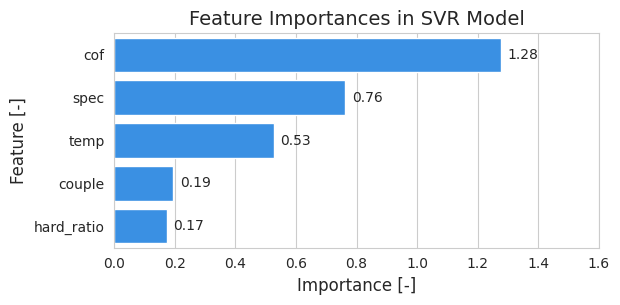

In [84]:
# FEATURE IMPORTANCE
# Get support vectors and their coefficients
support_vectors = svr.support_vectors_
support_vector_coefficients = svr.dual_coef_

# Feature importance matrix and names
a_f = np.abs(np.dot(support_vector_coefficients, support_vectors))
b_f = ([[element] for element in a_f[0]])
c_f = np.reshape(b_f,[1,-1])

feature_importances = np.ravel(c_f)
feature_names = X_dataset_pd.columns


svr_importance_df = pd.DataFrame({'Feature': feature_names, 'Coefficients': feature_importances})
svr_importance_df_sorted = svr_importance_df.sort_values(by='Coefficients', ascending=False)

fig, ax = plt.subplots(figsize=(6.3,3.15))

sns.set_style("whitegrid")
ax = sns.barplot(data=svr_importance_df_sorted, x='Coefficients', y='Feature', color='dodgerblue', fill = True)
ax.bar_label(ax.containers[0], svr_importance_df_sorted['Coefficients'].apply(lambda x: f"{x:.2f}"), padding = 5)

ax.set_xlim(0,1.6)
ax.set_xlabel("Importance [-]",fontsize=12)
ax.set_ylabel("Feature [-]",fontsize=12)

ax.set_title('Feature Importances in SVR Model',loc='center',fontsize=14)

plt.tight_layout()

download_plot = False

if download_plot == True:
  file_format = "svg"
  file_path =  f"svr_importances.{file_format}"
  plt.savefig(file_path)
  files.download(file_path)
  print(f"Plot downloaded successfully at Desktop/{file_path}")

plt.show()

download_plot = False

#SVR data split

In [85]:
for ratio in [0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]:

  train_pd, test_pd = np.split(dataset_pd.sample(frac=1, random_state=16), [int(ratio*len(dataset_pd))])
  dataset_np = np.array(dataset_pd)
  train_np, test_np = np.array(train_pd), np.array(test_pd)

  #All NUMPY ARRAYS - UNScaled
  X_dataset_np = get_xy(dataset_np)[0]
  y_dataset_np = get_xy(dataset_np)[1]

  X_train_np = get_xy(train_np)[0]
  y_train_np = get_xy(train_np)[1]

  X_test_np = get_xy(test_np)[0]
  y_test_np = get_xy(test_np)[1]

  #All PANDAS DATAFRAMES - UNScaled
  X_dataset_pd = get_xy(dataset_pd)[0]
  y_dataset_pd = get_xy(dataset_pd)[1]

  X_train_pd = get_xy(train_pd)[0]
  y_train_pd = get_xy(train_pd)[1]

  X_test_pd = get_xy(test_pd)[0]
  y_test_pd = get_xy(test_pd)[1]

  #All NUMPY ARRAYS - Scaled .- MINMAX Good because only positive values
  scaler_X = MinMaxScaler()
  scaler_y = MinMaxScaler()

  X_train_np_scaled = scaler_X.fit_transform(X_train_np)
  y_train_np_scaled = scaler_y.fit_transform(y_train_np.reshape(-1, 1))

  X_test_np_scaled = scaler_X.transform(X_test_np)
  y_test_np_scaled = scaler_y.transform(y_test_np)

  #All PANDAS DATAFRAMES - Scaled
  X_train_pd_scaled = pd.DataFrame(X_train_np_scaled, columns = list(dataset_pd.columns[:-1]))
  y_train_pd_scaled = pd.DataFrame(y_train_np_scaled, columns = dataset_pd.columns[-1:])

  X_test_pd_scaled = pd.DataFrame(X_test_np_scaled, columns = list(dataset_pd.columns[:-1]))
  y_test_pd_scaled = pd.DataFrame(y_test_np_scaled, columns = dataset_pd.columns[-1:])

  # Polynomial features
  best_C = 1.3
  best_eps = 0.1
  best_gamma = 'auto'
  best_kernel = 'rbf'
  best_poly_degree_svm = 1

  poly_features_svm = PolynomialFeatures(degree=best_poly_degree_svm)
  X_train_svm_poly = poly_features_svm.fit_transform(X_train_np_scaled)
  X_test_svm_poly = poly_features_svm.transform(X_test_np_scaled)

  # Define and train SVR model
  svr = SVR(kernel=best_kernel, gamma=best_gamma, C=best_C, epsilon=best_eps,) #degree=best_degree
  svr.fit(X_train_np_scaled, y_train_np_scaled.reshape(-1))

  # Predict
  y_pred_svr_uns = svr.predict(X_test_np_scaled)

  # Unscale predictions
  y_test_svr = scaler_y.inverse_transform(y_test_np_scaled.reshape(-1, 1))
  y_pred_svr = scaler_y.inverse_transform(y_pred_svr_uns.reshape(-1, 1))

  # Evaluate model
  eval_svr = eval_model(svr, y_test_svr, y_pred_svr)
  mse_svr = eval_svr ['mse']
  rmse_svr = eval_svr ['rmse']

  cross_svr = crossval_model(svr, X_train_np_scaled, y_train_np_scaled.reshape(-1), X_test_np_scaled, y_test_np_scaled)
  r2_svr_test = cross_svr ['test_score']
  r2_svr_train = cross_svr ['mean_train_score']

  print(f"ratio: {ratio}"), print(eval_svr), print(cross_svr)

ratio: 0.6
{'r2': 0.37416720947974247, 'mse': 2.0415135017416276e+16, 'rmse': 142881541.90593085, 'coeff': None, 'intercept': array([0.46636328])}
{'mean_train_score': 0.312, 'test_score': 0.374, 'score_difference': 0.062}
ratio: 0.65
{'r2': 0.4545566831502662, 'mse': 1.8034465936473972e+16, 'rmse': 134292464.1834901, 'coeff': None, 'intercept': array([0.54064387])}
{'mean_train_score': 0.353, 'test_score': 0.455, 'score_difference': 0.10200000000000004}
ratio: 0.7
{'r2': 0.4590118087282201, 'mse': 1.4439705190801576e+16, 'rmse': 120165324.41100293, 'coeff': None, 'intercept': array([0.46808206])}
{'mean_train_score': 0.068, 'test_score': 0.459, 'score_difference': 0.391}
ratio: 0.75
{'r2': 0.48203886275075236, 'mse': 1.5156536248714728e+16, 'rmse': 123111885.08310124, 'coeff': None, 'intercept': array([0.47708024])}
{'mean_train_score': 0.07, 'test_score': 0.482, 'score_difference': 0.412}
ratio: 0.8
{'r2': 0.4293098950826497, 'mse': 1.8558235292076896e+16, 'rmse': 136228614.0723633, 

# RF Grid search

In [86]:
# Define objective function
def objective(params):
    n_estimators = params['n_estimators']
    max_depth = params['max_depth']
    min_samples_split = params['min_samples_split']
    min_samples_leaf = params['min_samples_leaf']
    min_weight_fraction_leaf = params['min_weight_fraction_leaf']
    max_leaf_nodes = params['max_leaf_nodes']
    min_impurity_decrease = params['min_impurity_decrease']
    poly_degree_rf = params['poly_degree_rf']

    try:
        # Polynomial features
        poly_features_rf = PolynomialFeatures(degree=poly_degree_rf)
        X_train_rf_poly = poly_features_rf.fit_transform(X_train_np_scaled)
        X_test_rf_poly = poly_features_rf.transform(X_test_np_scaled)

        # Define and train Random Forest model
        forest = RandomForestRegressor(n_estimators=n_estimators,
                                       max_depth=max_depth,
                                       min_samples_split=min_samples_split,
                                       min_samples_leaf=min_samples_leaf,
                                       min_weight_fraction_leaf=min_weight_fraction_leaf,
                                       max_leaf_nodes=max_leaf_nodes,
                                       min_impurity_decrease=min_impurity_decrease,
                                       random_state=16)
        forest.fit(X_train_rf_poly, y_train_np_scaled.reshape(-1))

        # Predict
        y_pred_forest_uns = forest.predict(X_test_rf_poly)

        # Unscale
        y_test_forest = scaler_y.inverse_transform(y_test_np_scaled.reshape(-1, 1))
        y_pred_forest = scaler_y.inverse_transform(y_pred_forest_uns.reshape(-1, 1))

        # Calculate MSE
        mse_forest = mean_squared_error(y_test_forest, y_pred_forest)

        return {'loss': mse_forest, 'status': STATUS_OK}

    except Exception as e:
        # If an exception occurs, return STATUS_FAIL
        return {'loss': np.inf, 'status': STATUS_FAIL}

# Define search space
space = {
    'n_estimators': hp.choice('n_estimators', [50, 100, 150, 200, 250]),
    'max_depth': hp.choice('max_depth', [None, 10, 20, 30, 40, 50]),
    'min_samples_split': hp.choice('min_samples_split', [2, 5]),
    'min_samples_leaf': hp.choice('min_samples_leaf', [1, 2]),
    'min_weight_fraction_leaf': hp.uniform('min_weight_fraction_leaf', 0.0, 0.5),
    'max_leaf_nodes': hp.choice('max_leaf_nodes', [None, 10, 20, 30, 40, 50]),
    'min_impurity_decrease': hp.uniform('min_impurity_decrease', 0.0, 0.5),
    'poly_degree_rf': hp.choice('poly_degree_rf', [1, 2, 3])
}

# Perform hyperparameter optimization
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=5000, trials=trials)

print("Best hyperparameters INDEX:", best)

100%|██████████| 5/5 [00:00<00:00,  6.57trial/s, best loss: 2.2331505042636452e+16]
Best hyperparameters INDEX: {'max_depth': 1, 'max_leaf_nodes': 2, 'min_impurity_decrease': 0.4168602220186194, 'min_samples_leaf': 1, 'min_samples_split': 0, 'min_weight_fraction_leaf': 0.4160026184641919, 'n_estimators': 4, 'poly_degree_rf': 1}


Best params

In [87]:
# New list
n_estimators_list = [50, 100, 150, 200, 250]
max_depth_list = [None, 10, 20, 30, 40, 50]
min_samples_split_list = [2, 5]
min_samples_leaf_list = [1, 2]
min_weight_fraction_leaf_list = hp.uniform('min_weight_fraction_leaf', 0.0, 0.5),
max_leaf_nodes_list = [None, 10, 20, 30, 40, 50]
min_impurity_decrease_list = hp.uniform('min_impurity_decrease', 0.0, 0.5)
poly_degree_rf_list = [1, 2, 3]

# Map indices to actual values
best_n_estimators = n_estimators_list[best['n_estimators']]
best_max_depth = max_depth_list[best['max_depth']]
best_min_samples_split = min_samples_split_list[best['min_samples_split']]
best_min_samples_leaf = min_samples_leaf_list[best['min_samples_leaf']]
best_min_weight_fraction_leaf = best['min_weight_fraction_leaf']
best_max_leaf_nodes = max_leaf_nodes_list[best['max_leaf_nodes']]
best_min_impurity_decrease = best['min_impurity_decrease']
best_poly_degree_rf = poly_degree_rf_list[best['poly_degree_rf']]

print(f"best_n_estimators: {best_n_estimators}\nbest_max_depth: {best_max_depth}\nbest_min_samples_split: {best_min_samples_split}\nbest_min_samples_leaf: {best_min_samples_leaf}\nbest_min_weight_fraction_leaf: {best_min_weight_fraction_leaf}\nbest_max_leaf_nodes: {best_max_leaf_nodes}\nbest_min_impurity_decrease: {best_min_impurity_decrease}\nbest_poly_degree_rf: {best_poly_degree_rf}")

best_n_estimators: 250
best_max_depth: 10
best_min_samples_split: 2
best_min_samples_leaf: 2
best_min_weight_fraction_leaf: 0.4160026184641919
best_max_leaf_nodes: 20
best_min_impurity_decrease: 0.4168602220186194
best_poly_degree_rf: 2


In [88]:
# best_n_estimators: 50
# best_max_depth: 10
# best_min_samples_split: 2
# best_min_samples_leaf: 1
# best_min_weight_fraction_leaf: 0.018649257559030956
# best_max_leaf_nodes: None
# best_min_impurity_decrease: 9.47344833598598e-06
# best_poly_degree_rf: 3

# RF One

In [89]:
# TRAIN MODEL
# Polynomial features
best_n_estimators = 50
best_max_depth = 10
best_min_samples_split = 2
best_min_samples_leaf = 1
best_min_weight_fraction_leaf = 0.018649257559030956
best_max_leaf_nodes = None
best_min_impurity_decrease = 9.47344833598598e-06
best_poly_degree_rf = 3

poly_features_rf = PolynomialFeatures(degree=best_poly_degree_rf)
X_train_rf_poly = poly_features_rf.fit_transform(X_train_np_scaled)
X_test_rf_poly = poly_features_rf.transform(X_test_np_scaled)

# Define and train Random Forest model
forest = RandomForestRegressor(n_estimators=best_n_estimators,
                                max_depth=best_max_depth,
                                min_samples_split=best_min_samples_split,
                                min_samples_leaf=best_min_samples_leaf,
                                min_weight_fraction_leaf=best_min_weight_fraction_leaf,
                                max_leaf_nodes=best_max_leaf_nodes,
                                min_impurity_decrease=best_min_impurity_decrease,
                                random_state=16)

forest.fit(X_train_rf_poly, y_train_np_scaled.reshape(-1))

# Predict
y_pred_forest_uns = forest.predict(X_test_rf_poly)

# Unscale
y_test_forest = scaler_y.inverse_transform(y_test_np_scaled.reshape(-1, 1))
y_pred_forest = scaler_y.inverse_transform(y_pred_forest_uns.reshape(-1, 1))

# Evaluate, Cross validation
eval_forest = eval_model(forest, y_test_forest, y_pred_forest)
mse_forest = eval_forest ['mse']
rmse_forest = eval_forest ['rmse']

cross_forest = crossval_model(forest, X_train_rf_poly, y_train_np_scaled.reshape(-1), X_test_rf_poly, y_test_np_scaled)
r2_forest_test = cross_forest ['test_score']
r2_forest_train = cross_forest ['mean_train_score']

eval_forest, cross_forest

({'r2': -362.12222352385726,
  'mse': 5856025406618727.0,
  'rmse': 76524671.8818103,
  'coeff': None,
  'intercept': None},
 {'mean_train_score': 0.543,
  'test_score': -362.122,
  'score_difference': 362.665})

# GA Grid search

In [90]:
# Define objective function
def objective(params):
    population_size = params['population_size']
    generations = params['generations']
    tournament_size = params['tournament_size']
    stopping_criteria = params['stopping_criteria']
    p_crossover = params['p_crossover']
    p_subtree_mutation = params['p_subtree_mutation']
    p_hoist_mutation = params['p_hoist_mutation']
    p_point_mutation = params['p_point_mutation']
    p_point_replace = params['p_point_replace']
    max_samples = params['max_samples']
    parsimony_coefficient = params['parsimony_coefficient']
    # function_set = params['function_set']
    # metric = params['metric']
    poly_degree_ga = params['poly_degree_ga']

    try:
        # Polynomial features
        poly_features_ga = PolynomialFeatures(degree=poly_degree_ga)
        X_train_ga_poly = poly_features_ga.fit_transform(X_train_np_scaled)
        X_test_ga_poly = poly_features_ga.transform(X_test_np_scaled)


        function_set = ['add', 'sub', 'mul', 'div']
        # Define and train Symbolic Regressor
        gasr = SymbolicRegressor(population_size=population_size,
                                generations=generations,
                                tournament_size=tournament_size,
                                stopping_criteria=stopping_criteria,
                                p_crossover=p_crossover,
                                p_subtree_mutation=p_subtree_mutation,
                                p_hoist_mutation=p_hoist_mutation,
                                p_point_mutation=p_point_mutation,
                                p_point_replace=p_point_replace,
                                max_samples=max_samples,
                                parsimony_coefficient=parsimony_coefficient,
                                function_set=function_set,
                                random_state=16)

        gasr.fit(X_train_ga_poly, y_train_np_scaled.reshape(-1))

        # Predict
        y_pred_ga_uns = gasr.predict(X_test_ga_poly)

        # Unscale
        y_test_ga = scaler_y.inverse_transform(y_test_np_scaled.reshape(-1, 1))
        y_pred_ga = scaler_y.inverse_transform(y_pred_ga_uns.reshape(-1, 1))

        # Calculate MSE
        mse_ga = mean_squared_error(y_test_ga, y_pred_ga)

        return {'loss': mse_ga, 'status': STATUS_OK}

    except Exception as e:
        # If an exception occurs, return STATUS_FAIL
        return {'loss': np.inf, 'status': STATUS_FAIL}

# Define search space
space = {
    'population_size': hp.choice('population_size', [100, 200, 300, 500, 1000]),
    'generations': hp.choice('generations', [100, 150, 200]),
    'tournament_size': hp.choice('tournament_size', [10, 20, 30]),
    'stopping_criteria': hp.choice('stopping_criteria', [0.01, 0.001, 0.0001]),
    'p_crossover': hp.uniform('p_crossover', 0.5, 1.0),
    'p_subtree_mutation': hp.uniform('p_subtree_mutation', 0.05, 0.2),
    'p_hoist_mutation': hp.uniform('p_hoist_mutation', 0.05, 0.2),
    'p_point_mutation': hp.uniform('p_point_mutation', 0.05, 0.2),
    'p_point_replace': hp.uniform('p_point_replace', 0.05, 0.2),
    'max_samples': hp.choice('max_samples', [None, 0.5, 0.75, 1.0]),
    'parsimony_coefficient': hp.choice('parsimony_coefficient', [0.001, 0.01, 0.1]),
    # 'function_set': hp.choice('function_set', ['add', 'sub', 'mul', 'div']),
    # 'metric': hp.choice('metric', ['mean absolute error', 'mean squared error', 'root mean squared error']),
    'poly_degree_ga': hp.choice('poly_degree_ga', [1,2,3])
}

# Perform hyperparameter optimization
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=30, trials=trials)

print("Best hyperparameters INDEX:", best)

100%|██████████| 10/10 [01:45<00:00, 10.56s/trial, best loss: 1763834643764598.8]
Best hyperparameters INDEX: {'generations': 0, 'max_samples': 3, 'p_crossover': 0.5176349023413259, 'p_hoist_mutation': 0.07592769794369467, 'p_point_mutation': 0.06251560242319085, 'p_point_replace': 0.13730825713411515, 'p_subtree_mutation': 0.1525547711743132, 'parsimony_coefficient': 0, 'poly_degree_ga': 2, 'population_size': 3, 'stopping_criteria': 0, 'tournament_size': 2}


Best params lists

In [91]:
# New lists based on hyperspace
population_size_list = [100, 200, 300, 500, 1000]
generations_list = [50, 100, 150]
tournament_size_list = [10, 20, 30]
stopping_criteria_list = [0.01, 0.001, 0.0001]
p_crossover_list = [0.5, 1.0]
p_subtree_mutation_list = [0.05, 0.2]
p_hoist_mutation_list = [0.05, 0.2]
p_point_mutation_list = [0.05, 0.2]
p_point_replace_list = [0.05, 0.2]
max_samples_list = [None, 0.5, 0.75, 1.0]
parsimony_coefficient_list = [0.001, 0.01, 0.1]
# function_set_list = ['add', 'sub', 'mul', 'div']
poly_degree_ga_list = [1,2,3]

# Map indices to actual values
best_population_size = population_size_list[best['population_size']]
best_generations = generations_list[best['generations']]
best_tournament_size = tournament_size_list[best['tournament_size']]
best_stopping_criteria = stopping_criteria_list[best['stopping_criteria']]
best_p_crossover = best['p_crossover']
best_p_subtree_mutation = best['p_subtree_mutation']
best_p_hoist_mutation = best['p_hoist_mutation']
best_p_point_mutation = best['p_point_mutation']
best_p_point_replace = best['p_point_replace']
best_max_samples = max_samples_list[best['max_samples']]
best_parsimony_coefficient = parsimony_coefficient_list[best['parsimony_coefficient']]
# best_function_set = function_set_list[best['function_set']]
best_poly_degree_ga = poly_degree_ga_list[best['poly_degree_ga']]

# Print best hyperparameters
print(f"best_population_size: {best_population_size}\nbest_generations: {best_generations}\nbest_tournament_size: {best_tournament_size}\nbest_stopping_criteria: {best_stopping_criteria}\nbest_p_crossover: {best_p_crossover}\nbest_p_subtree_mutation: {best_p_subtree_mutation}\nbest_p_hoist_mutation: {best_p_hoist_mutation}\nbest_p_point_mutation: {best_p_point_mutation}\nbest_p_point_replace: {best_p_point_replace}\nbest_max_samples: {best_max_samples}\nbest_parsimony_coefficient: {best_parsimony_coefficient}\nbest_poly_degree_ga: {best_poly_degree_ga}")


best_population_size: 500
best_generations: 50
best_tournament_size: 30
best_stopping_criteria: 0.01
best_p_crossover: 0.5176349023413259
best_p_subtree_mutation: 0.1525547711743132
best_p_hoist_mutation: 0.07592769794369467
best_p_point_mutation: 0.06251560242319085
best_p_point_replace: 0.13730825713411515
best_max_samples: 1.0
best_parsimony_coefficient: 0.001
best_poly_degree_ga: 3


In [92]:
# best_population_size: 200
# best_generations: 150
# best_tournament_size: 30
# best_stopping_criteria: 0.001
# best_p_crossover: 0.5148880365297297
# best_p_subtree_mutation: 0.17774003086744344
# best_p_hoist_mutation: 0.10969830464223353
# best_p_point_mutation: 0.0992553707945929
# best_p_point_replace: 0.16803561670665101
# best_max_samples: 0.5
# best_parsimony_coefficient: 0.001
# best_poly_degree_ga: 1

# GA One

In [93]:
best_population_size = 200
best_generations = 150
best_tournament_size = 30
best_stopping_criteria = 0.001
best_p_crossover = 0.5148880365297297
best_p_subtree_mutation = 0.17774003086744344
best_p_hoist_mutation = 0.10969830464223353
best_p_point_mutation = 0.0992553707945929
best_p_point_replace = 0.16803561670665101
best_max_samples = 0.5
best_parsimony_coefficient = 0.001
best_poly_degree_ga = 1

# Polynomial features
poly_features_ga = PolynomialFeatures(degree=best_poly_degree_ga)
X_train_ga_poly = poly_features_ga.fit_transform(X_train_np_scaled)
X_test_ga_poly = poly_features_ga.transform(X_test_np_scaled)

function_set = ['add', 'sub', 'mul', 'div']
# Define and train Symbolic Regressor
gasr = SymbolicRegressor(population_size=best_population_size,
                        generations=best_generations,
                        tournament_size=best_tournament_size,
                        stopping_criteria=best_stopping_criteria,
                        p_crossover=best_p_crossover,
                        p_subtree_mutation=best_p_subtree_mutation,
                        p_hoist_mutation=best_p_hoist_mutation,
                        p_point_mutation=best_p_point_mutation,
                        p_point_replace=best_p_point_replace,
                        max_samples=best_max_samples,
                        parsimony_coefficient=best_parsimony_coefficient,
                        function_set=function_set,
                        verbose=1,
                        random_state=16)

gasr.fit(X_train_ga_poly, y_train_np_scaled.reshape(-1))

# Predict
y_pred_ga_uns = gasr.predict(X_test_ga_poly)

# Unscale
y_test_ga = scaler_y.inverse_transform(y_test_np_scaled.reshape(-1, 1))
y_pred_ga = scaler_y.inverse_transform(y_pred_ga_uns.reshape(-1, 1))


# Evaluate, Cross validation
eval_ga = eval_model(gasr, y_test_ga, y_pred_ga)
mse_ga = eval_ga['mse']
rmse_ga = eval_ga['rmse']

cross_ga = crossval_model(gasr, X_train_ga_poly, y_train_np_scaled.reshape(-1), X_test_ga_poly, y_test_np_scaled)
r2_ga_test = cross_ga['test_score']
r2_ga_train = cross_ga['mean_train_score']

eval_ga, cross_ga, str(gasr._program)
print(f"{eval_ga}, {cross_ga}, equation: {str(gasr._program)}")

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    27.92           4634.2       11         0.140294         0.262116     46.97s
   1     7.96         0.539537       15         0.134474         0.196053     34.98s
   2     8.08         0.580211        3         0.127964         0.214653     33.93s
   3     7.92         0.599421       21        0.0827739          0.16901     35.24s
   4     9.20         0.673241       23        0.0991586         0.199368     38.05s
   5     8.14         0.374192       25        0.0875849         0.192473     34.13s
   6    11.02         0.523607        7        0.0866179          0.23671     36.64s
   7     8.70         0.394841        9         0.105914         0.218186     27.64s
   8     7.70         0.466601        9        0.0874117         0.214573  

# NN grid search

Delete # for starting the grid search

In [94]:
def objective(params):
    hidden_layers = params['hidden_layers']
    hidden_units = params['hidden_units']
    batch_size = params['batch_size']
    activation = params['activation']
    learning_rate = params['learning_rate']
    poly_degree_nn = params['poly_degree_nn']


    try:

        # Polynomial features
        poly_features_nn = PolynomialFeatures(degree=poly_degree_nn)
        X_train_nn_poly = poly_features_nn.fit_transform(X_train_np_scaled)
        X_test_nn_poly = poly_features_nn.transform(X_test_np_scaled)

        # Define model architecture based on hyperparameters
        layers = [Dense(X_train_nn_poly.shape[1], name="layer1")]
        for _ in range(hidden_layers):
            layers.append(Dense(hidden_units, activation=activation))
        layers.append(Dense(1, activation="linear", name="layer3"))
        model = Sequential(layers)

        optimizer = Adam(learning_rate=learning_rate)
        model.compile(optimizer=optimizer, loss='mean_squared_error')

        epochs = 2000
        history = model.fit(X_train_nn_poly, y_train_np_scaled, epochs=epochs,
                            batch_size=batch_size, validation_split=0.2, verbose=0)

        y_pred_nn_scaled = model.predict(X_test_nn_poly)

        # Unscale
        y_pred_nn = scaler_y.inverse_transform(y_pred_nn_scaled.reshape(-1, 1))
        y_test_nn = scaler_y.inverse_transform(y_test_np_scaled.reshape(-1, 1))

        mse = mean_squared_error(y_test_nn, y_pred_nn)

        return {'loss': mse, 'status': STATUS_OK}

    except Exception as e:
        # If NaN values are encountered, return high loss to indicate failure
        return {'loss': np.inf, 'status': STATUS_FAIL}

# Define search space and perform hyperparameter optimization

space = {
    'hidden_layers': hp.choice('hidden_layers', [1,2,3,4,5,6,7,8,9,10]),
    'hidden_units': hp.choice('hidden_units', [1,2,3,4,5,6,7,8,9,10]),
    'batch_size': hp.choice('batch_size', [1,2,4,8,16,32,40]),
    'activation': hp.choice('activation', ["relu", "sigmoid", "tanh", "linear", "leaky_relu", "elu", "swish", "softplus", "selu"]),
    'learning_rate': hp.loguniform('learning_rate', np.log(1e-4), np.log(1)),
    'poly_degree_nn': hp.choice('poly_degree_nn', [1, 2, 3])
    }

trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=100, trials=trials)

print("Best hyperparameters INDEX:", best)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step

100%|██████████| 1/1 [00:02<00:00,  2.82s/trial, best loss: 3073770686613746.5]
Best hyperparameters INDEX: {'activation': 4, 'batch_size': 6, 'hidden_layers': 3, 'hidden_units': 5, 'learning_rate': 0.00017401298879836976, 'poly_degree_nn': 2}


In [95]:
# Lists corresponding to each hyperparameter
hidden_layers_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
hidden_units_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
batch_size_list = [1, 2, 4, 8, 16, 32, 40]
activation_list = ["relu", "sigmoid", "tanh", "linear", "leaky_relu", "elu", "swish", "softplus", "selu"]
poly_degree_nn_list = [1, 2, 3]

# Map indices to actual values
best_hidden_layers = hidden_layers_list[best['hidden_layers']]
best_hidden_units = hidden_units_list[best['hidden_units']]
best_batch_size = batch_size_list[best['batch_size']]
best_activation = activation_list[best['activation']]
best_learning_rate = best['learning_rate']
best_poly_degree_nn = poly_degree_nn_list[best['poly_degree_nn']]

print(f"best_hidden_layers: {best_hidden_layers}\nbest_hidden_units: {best_hidden_units}\nbest_batch_size: {best_batch_size}\nbest_activation: {best_activation}\nbest_learning_rate: {best_learning_rate}\nbest_poly_degree_nn: {best_poly_degree_nn}")

best_hidden_layers: 4
best_hidden_units: 6
best_batch_size: 40
best_activation: leaky_relu
best_learning_rate: 0.00017401298879836976
best_poly_degree_nn: 3


# NN best params

For using best params, either add them into the list or change the variables to best_learning rate, best_...

In [96]:
class CustomEarlyStopping(Callback):
    def __init__(self, monitor='val_loss', patience=0, verbose=0, restore_best_weights=True):
        super(CustomEarlyStopping, self).__init__()
        self.monitor = monitor
        self.patience = patience
        self.verbose = verbose
        self.restore_best_weights = restore_best_weights  # New parameter
        self.wait = 0
        self.stopped_epoch = 0
        self.best = np.Inf if 'loss' in monitor else -np.Inf
        self.best_weights = None  # Variable to store the best weights

    def on_epoch_end(self, epoch, logs=None):
        current = logs.get(self.monitor)
        if current is None:
            warnings.warn("Early stopping requires %s available!" % self.monitor, RuntimeWarning)

        if 'loss' in self.monitor:
            if current < self.best:
                self.best = current
                self.wait = 0
                if self.restore_best_weights:
                    self.best_weights = self.model.get_weights()  # Save current best weights
            else:
                self.wait += 1
                if self.wait >= self.patience:
                    self.stopped_epoch = epoch
                    self.model.stop_training = True
                    if self.restore_best_weights and self.best_weights is not None:
                        self.model.set_weights(self.best_weights)  # Restore best weights
                    if self.verbose > 0:
                        print("Epoch %05d: early stopping" % (epoch + 1))
        else:
            if current > self.best:
                self.best = current
                self.wait = 0
                if self.restore_best_weights:
                    self.best_weights = self.model.get_weights()  # Save current best weights
            else:
                self.wait += 1
                if self.wait >= self.patience:
                    self.stopped_epoch = epoch
                    self.model.stop_training = True
                    if self.restore_best_weights and self.best_weights is not None:
                        self.model.set_weights(self.best_weights)  # Restore best weights
                    if self.verbose > 0:
                        print("Epoch %05d: early stopping" % (epoch + 1))

In [97]:
def model_func():
    layers = [Dense(X_train_nn_poly.shape[1], name="layer1")]
    for _ in range(hidden_layers):
        layers.append(Dense(hidden_units, activation=activation))
    layers.append(Dense(1, activation="linear", name="layer3"))
    model = Sequential(layers)
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

Controll randomnes

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
hidden_layers: 1, hidden_units: 3, batch_size: 1, activation: leaky_relu, time of exe: 12.2s
{'r2': -25776.246785082818, 'mse': 4.1570634433011584e+17, 'rmse': 644752932.7813219, 'coeff': None, 'intercept': None}
 mean_train_r2: -1.029930656849605
 mean_val_r2: -1.3163357132122908
 test_r2: -54.175013000599236
 r2_diff: 52.858677287386946

 mean_train_mse: 5.617418409819288e+16
 mean_val_mse: 6.709265832949743e+16
 test_mse: 3284093911396715.0

 mean_train_rmse: 237010936.66367567
 mean_val_rmse: 259022505.44981113
 test_rmse: 57307014.50

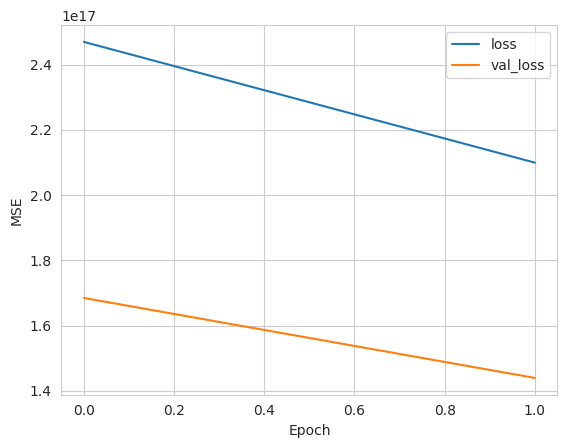

In [98]:
# ONE MODEL, EARLY STOPPING

set_final = {
  "hidden_layers": 1,
  "hidden_units": 3,
  "batch_size": 1,
  "activation": 'leaky_relu',
  "learning_rate": 0.00018022,
  "poly_degree_nn": 1,
}

set_def = set_final

# PARAMS
hidden_layers = set_def['hidden_layers']
hidden_units = set_def['hidden_units']
batch_size = set_def['batch_size']
activation = set_def['activation']
learning_rate = set_def['learning_rate']
poly_degree_nn = set_def['poly_degree_nn']

epochs = 2000
start = time.time()

# Polynomial features
poly_features_nn = PolynomialFeatures(degree=poly_degree_nn)
X_train_nn_poly = poly_features_nn.fit_transform(X_train_np_scaled)
X_test_nn_poly = poly_features_nn.transform(X_test_np_scaled)

# Define, compile model
layers = [Dense(X_train_nn_poly.shape[1], name="layer1")]
for _ in range(hidden_layers):
  layers.append(Dense(hidden_units, activation=activation))
layers.append(Dense(1, activation="linear", name="layer3"))
ann = Sequential(layers)

# Optimizer
optimizer = Adam(learning_rate=learning_rate)
ann.compile(optimizer=optimizer, loss='mean_squared_error')

# Early stopping callback
custom_early_stopping = CustomEarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)

# early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = ann.fit(X_train_nn_poly, y_train_np_scaled, epochs=epochs, batch_size=batch_size,
                  validation_split=0.2, verbose=0, callbacks=[custom_early_stopping])

# Predict
y_pred_nn_scaled = ann.predict(X_test_nn_poly)

# Unscale predictions
y_pred_nn = scaler_y.inverse_transform(y_pred_nn_scaled.reshape(-1, 1))
y_test_nn = scaler_y.inverse_transform(y_test_np_scaled.reshape(-1, 1))

# Evaluation
eval_nn = eval_model(ann, y_test_nn, y_pred_nn)
mse_nn = eval_nn['mse']
rmse_nn = eval_nn['rmse']

# Cross validation
# y_train_np_rescaled = scaler_y.inverse_transform(y_train_np_scaled)
# y_test_np_rescaled = scaler_y.inverse_transform(y_test_np_scaled)

crossval_nn = crossval_neural(model_func, X_train_nn_poly, y_train_np_scaled, X_test_nn_poly, y_test_np_scaled, epochs, batch_size)
mean_val_r2 = crossval_nn['mean_val_r2']
test_r2 = crossval_nn['test_r2']
r2_diff = np.abs(mean_val_r2-test_r2)

end = time.time()

print(f"hidden_layers: {hidden_layers}, hidden_units: {hidden_units}, batch_size: {batch_size}, activation: {activation}, time of exe: {end-start:.1f}s")
print(eval_nn)
print(f" mean_train_r2: {crossval_nn['mean_train_r2']}\n mean_val_r2: {crossval_nn['mean_val_r2']}\n test_r2: {crossval_nn['test_r2']}\n r2_diff: {r2_diff}\n\n mean_train_mse: {crossval_nn['mean_train_mse']}\n mean_val_mse: {crossval_nn['mean_val_mse']}\n test_mse: {crossval_nn['test_mse']}\n\n mean_train_rmse: {crossval_nn['mean_train_rmse']}\n mean_val_rmse: {crossval_nn['mean_val_rmse']}\n test_rmse: {crossval_nn['test_rmse']}")
plot_history(history)

# BIG 4 PICTURE

Added because of unstability of NN due to small dataset

In [99]:
mean_val_r2 = 0.194
test_r2 = 0.477

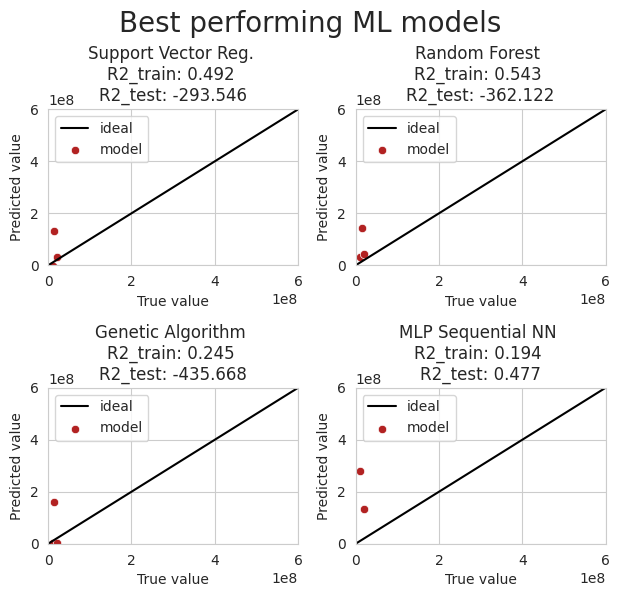

In [100]:
# PLOT
# Create a DataFrame
combo_sns = {
    "y_test_svr": y_test_svr.flatten(),
    "y_pred_svr": y_pred_svr.flatten(),

    "y_test_forest": y_test_forest.flatten(),
    "y_pred_forest": y_pred_forest.flatten(),

    "y_test_ga": y_test_ga.flatten(),
    "y_pred_ga": y_pred_ga.flatten(),

    "y_test_nn": y_test_nn.flatten(),
    "y_pred_nn": y_pred_nn.flatten(),

    "X_test_temp": X_test_np[:, 2],
}
combo_df = pd.DataFrame(combo_sns)

x_t = np.linspace(0, 6e10, 10)
y_t = x_t

# Create subplots using Seaborn
fig, axs = plt.subplots(2, 2, figsize=(6.3, 6.3))

#SVR
sns.lineplot(x=x_t, y=y_t, color='black', ax=axs[0,0], label='ideal')
sns.scatterplot(data=combo_df, x='y_test_svr', y='y_pred_svr', color='firebrick', ax=axs[0,0], label='model')
axs[0,0].set_title(f'Support Vector Reg. \nR2_train: {r2_svr_train:.3f} \nR2_test: {r2_svr_test:.3f}')
axs[0,0].set_xlabel('True value')
axs[0,0].set_xlim(0,6e8)
axs[0,0].set_ylabel('Predicted value')
axs[0,0].set_ylim(0,6e8)
axs[0,0].legend(loc='upper left')

#RF
sns.lineplot(x=x_t, y=y_t, color='black', ax=axs[0,1], label='ideal')
sns.scatterplot(data=combo_df, x='y_test_forest', y='y_pred_forest', color='firebrick', ax=axs[0,1], label='model')
axs[0,1].set_title(f'Random Forest \nR2_train: {r2_forest_train:.3f} \nR2_test: {r2_forest_test:.3f}')
axs[0,1].set_xlabel('True value')
axs[0,1].set_xlim(0,6e8)
axs[0,1].set_ylabel('Predicted value')
axs[0,1].set_ylim(0,6e8)
axs[0,1].legend(loc='upper left')

#GA
sns.lineplot(x=x_t, y=y_t, color='black', ax=axs[1,0], label='ideal')
sns.scatterplot(data=combo_df, x='y_test_ga', y='y_pred_ga', color='firebrick', ax=axs[1,0], label='model')
axs[1,0].set_title(f'Genetic Algorithm \nR2_train: {r2_ga_train:.3f} \nR2_test: {r2_ga_test:.3f}')
axs[1,0].set_xlabel('True value')
axs[1,0].set_xlim(0,6e8)
axs[1,0].set_ylabel('Predicted value')
axs[1,0].set_ylim(0,6e8)
axs[1,0].legend(loc='upper left')

#NN
sns.lineplot(x=x_t, y=y_t, color='black', ax=axs[1,1], label='ideal')
sns.scatterplot(data=combo_df, x='y_test_nn', y='y_pred_nn', color='firebrick', ax=axs[1,1], label='model')
axs[1,1].set_title(f'MLP Sequential NN \nR2_train: {mean_val_r2:.3f} \nR2_test: {test_r2:.3f}')
axs[1,1].set_xlabel('True value')
axs[1,1].set_xlim(0,6e8)
axs[1,1].set_ylabel('Predicted value')
axs[1,1].set_ylim(0,6e8)
axs[1,1].legend(loc='upper left')

fig.suptitle("Best performing ML models", fontsize=20, y=0.94)
plt.tight_layout()

download_plot = False

if download_plot == True:
  file_format = "svg"
  file_path =  f"combo_plots_final.{file_format}"
  plt.savefig(file_path)
  files.download(file_path)
  print(f"Plot downloaded successfully at Desktop/{file_path}")

plt.show()

download_plot = False